## ZAD1

In [1]:
import pybedtools as pbt

# Read cpg islands
def parse_cpg_island(entry):
    split = entry.split()
    return '\t'.join(split[1:4])

with open('cpgIslandExt.txt', 'r') as f:
    cpg_islands = [parse_cpg_island(line) for line in f.readlines()]
    islands = pbt.BedTool('\n'.join(cpg_islands), from_string=True)

for island in islands[:3]:
    print(island)


chr1	28735	29810

chr1	135124	135563

chr1	327790	328229



In [2]:
# Filter autosomal only
import numpy as np

def filter_autosomal(x):
    autosomal_chromosomes = [f'chr{id}' for id in range(1, 23)]
    return [el for el in x if el[0] in autosomal_chromosomes]

islands = pbt.BedTool(filter_autosomal(islands))

np.unique( [island[0] for island in islands])

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9'],
      dtype='<U5')

In [3]:
def to_chromosome(entry):
    split = entry.split()
    return f'{split[0]}\t0\t{split[1]}'

# Read chromosome sizes into Bed Tool containing full chromosomes only \
with open('hg19.chrom.sizes', 'r') as f:
    chromosomes = [to_chromosome(line) for line in f.readlines()]
    chromosomes = pbt.BedTool('\n'.join(chromosomes), from_string=True)

for chr in chromosomes[:3]:
    print(chr)


chr1	0	249250621

chr2	0	243199373

chr3	0	198022430



In [4]:
# Get shores and shelves

shore_size = 2000
shelf_size = 2000

def make_bigger(what, how_much):
    what.start -= how_much
    what.stop += how_much
    return what

def make_bigger_tool(tool, how_much):
    return tool.each(lambda x: make_bigger(x, how_much))

islands_and_shores = make_bigger_tool(islands, shore_size).merge().intersect(chromosomes)
islands_and_shores.saveas('islands_and_shores.bed')
shores = islands_and_shores.subtract(islands)

islands_and_shores_and_shelves = make_bigger_tool(islands_and_shores, shelf_size).merge().intersect(chromosomes)
shelves = islands_and_shores_and_shelves.subtract(islands_and_shores)

seas = chromosomes.subtract(islands_and_shores_and_shelves)

In [5]:
islands.sort().saveas('cpg.bed')
shores.sort().saveas('shores.bed')
shelves.sort().saveas('shelves.bed')
seas.sort().saveas('seas.bed')

<BedTool(seas.bed)>

## ZAD 2

In [6]:
def parse_point(entry):
    split = entry.split()
    middle = (int(split[1]) + int(split[2])) // 2 
    return f'{split[0]}\t{middle}\t{middle+1}'

with open('wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed', 'r') as f:
    methylations = [parse_point(line) for line in f.readlines()]
    methylations = pbt.BedTool('\n'.join(methylations), from_string=True)

methylations = pbt.BedTool(filter_autosomal(methylations))

methylations = methylations.sort()

for point in methylations[::1000]:
    print(point)

chr1	15890	15891

chr1	1266682	1266683

chr1	2039696	2039697

chr1	2794142	2794143

chr1	3477720	3477721

chr1	6153098	6153099

chr1	8164821	8164822

chr1	10707959	10707960

chr1	13886728	13886729

chr1	16941451	16941452

chr1	19665530	19665531

chr1	22935930	22935931

chr1	25942852	25942853

chr1	27884370	27884371

chr1	32054485	32054486

chr1	35250254	35250255

chr1	38470565	38470566

chr1	41886285	41886286

chr1	44821021	44821022

chr1	47902396	47902397

chr1	53990224	53990225

chr1	59825670	59825671

chr1	68027642	68027643

chr1	84524152	84524153

chr1	91853114	91853115

chr1	100503845	100503846

chr1	110614475	110614476

chr1	115212009	115212010

chr1	143183465	143183466

chr1	149684586	149684587

chr1	152056894	152056895

chr1	154908806	154908807

chr1	156390983	156390984

chr1	160079682	160079683

chr1	164572188	164572189

chr1	171285136	171285137

chr1	179847187	179847188

chr1	186649379	186649380

chr1	201717217	201717218

chr1	204948607	204948608

chr1	209404871	209404872

ch

## ZAD 3

In [7]:
# calcuate stats about methylation position
def get_hits(region_name, methylations):
    regions = pbt.BedTool(f'{region_name}.bed')
    return regions.intersect(methylations).count()


import pandas as pd
df = pd.DataFrame({'region': ['cpg', 'shores', 'shelves', 'seas']})

df['hits'] = df['region'].apply(lambda region_name: get_hits(region_name, methylations))

df['perc'] = df['hits'] / sum(df['hits'])
df

,region,hits,perc
0,cpg,132094,0.280532
1,shores,122913,0.261034
2,shelves,45457,0.096538
3,seas,170406,0.361896


In [8]:
sum(df['hits'])

470870

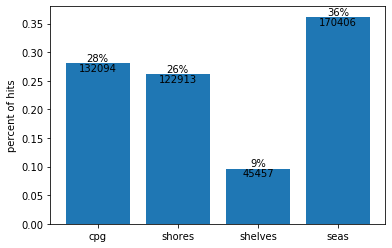

In [9]:
# plot results

import matplotlib.pyplot as plt

bar = plt.bar(range(len(df['hits'])), df['perc'], align='center')
plt.xticks(range(len(df['region'])), df['region'])

for i, rect in enumerate(bar):
    plt.text(
        rect.get_x() + rect.get_width()/2.0, 
        rect.get_height(), 
        f"{int(df['perc'][i]*100)}%", 
        ha='center', va='bottom')
    plt.text(
        rect.get_x() + rect.get_width()/2.0, 
        rect.get_height(), 
        f"{df['hits'][i]}", 
        ha='center', va='top')

plt.ylabel('percent of hits')

plt.show()
